In [76]:
import numpy as np
import pandas as pd
import pyterrier as pt
import time
import os
if not pt.started():
  pt.init()

In [77]:
start = time.time()

In [78]:
b = False # vaswani / trec
if b:
    dataset = pt.datasets.get_dataset("vaswani")
    indexref = dataset.get_index()
    topics = dataset.get_topics()
    qrels = dataset.get_qrels()
else:
    dataset = pt.datasets.get_dataset("trec-deep-learning-docs")
    corpus = dataset.get_corpus()
    index_path = './trec_dldocs_index'
    if not os.path.isdir(index_path):
        indexer = pt.TRECCollectionIndexer(index_path)
        index_properties = {'block.indexing': 'true', 'invertedfile.lexiconscanner': 'pointers'}
        indexer.setProperties(**index_properties)

        indexref = indexer.index(dataset.get_corpus())
    else:
        indexref = pt.autoclass("org.terrier.querying.IndexRef").of(os.path.join(index_path, "data.properties"))

    topics = dataset.get_topics('test')
    qrels = dataset.get_qrels('test')

In [79]:
print(type(qrels))
print(len(topics))
print(len(qrels))

<class 'pandas.core.frame.DataFrame'>
200
16258


In [80]:
#this ranker will make the candidate set of documents for each query
BM25 = pt.BatchRetrieve(indexref, controls = {"wmodel": "BM25"})

#these rankers we will use to re-rank the BM25 results
TF_IDF =  pt.BatchRetrieve(indexref, controls = {"wmodel": "TF_IDF"})
PL2 =  pt.BatchRetrieve(indexref, controls = {"wmodel": "PL2"})
DPH = pt.BatchRetrieve(indexref, controls = {"wmodel": "DPH"})
PL2F =  pt.BatchRetrieve(indexref, controls = {"wmodel": "PL2F"})

In [81]:
feature_batch_retriever = pt.FeaturesBatchRetrieve(indexref, controls = {"wmodel": "BM25"}, features=["WMODEL:TF_IDF", "WMODEL:PL2", "WMODEL:DPH", "WMODEL:BM25"]) 

In [82]:
type(feature_batch_retriever)

pyterrier.batchretrieve.FeaturesBatchRetrieve

In [83]:
(BM25 %2).transform("world")

,qid,docid,docno,rank,score,query
0,1,1821403,D1715600,0,3.875790,world
1,1,1093198,D3051298,1,3.870458,world


In [84]:
(PL2).transform("world")

,qid,docid,docno,rank,score,query
0,1,1821403,D1715600,0,6.304447,world
1,1,1093198,D3051298,1,6.068830,world
2,1,919708,D262132,2,5.900087,world
3,1,148486,D1759484,3,5.863672,world
4,1,1318667,D396706,4,5.808389,world
...,...,...,...,...,...,...
995,1,182820,D710517,995,4.096101,world
996,1,1714426,D1866160,996,4.095477,world
997,1,861041,D2366639,997,4.095193,world
998,1,2910972,D697217,998,4.094977,world


In [85]:
train_topics, valid_topics, test_topics = np.split(topics, [int(.6*len(topics)), int(.8*len(topics))])

In [86]:
from sklearn.ensemble import RandomForestRegressor

ltr_model = feature_batch_retriever >> pt.pipelines.LTR_pipeline(RandomForestRegressor(n_estimators=400))
ltr_model.fit(train_topics, qrels)

In [87]:
results = pt.pipelines.Experiment([TF_IDF, BM25, PL2, ltr_model], test_topics, qrels, ["map", "ndcg"], names=["TF-IDF", "BM25 algorithm", "PL2 Baseline", "LTR Random Forest"])
results

,name,map,ndcg
0,TF-IDF,0.307107,0.643992
1,BM25 algorithm,0.306435,0.645085
2,PL2 Baseline,0.339192,0.674200
3,LTR Random Forest,0.184951,0.495573


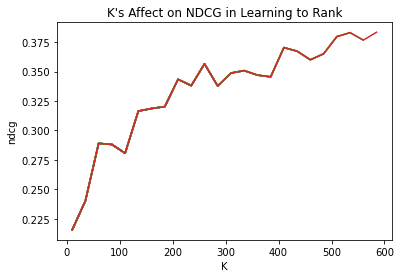

In [88]:
import matplotlib.pyplot as plt  # plotting libraries

def run_experiment(trained_model, mop, start= 10, finish = 600, incrementer = 25, top_k_model = BM25, title="sample title"):
    k_list = []
    moe_list = []
    for k in range(start, finish, incrementer):
        efficient_pipeline = top_k_model % k >> trained_model
        results = pt.pipelines.Experiment([efficient_pipeline], test_topics, qrels, [mop], names=["model"])
        k_list.append(k)
        moe_list.append(results[mop].iloc[0])
        
        plt.plot(k_list, moe_list)
        plt.xlabel("K")
        plt.ylabel(mop)
        file_name = title.replace(" ", "-")
        plt.title(title)
        plt.savefig(file_name)
        
run_experiment(ltr_model, "ndcg", title = "K's Affect on NDCG in Learning to Rank")

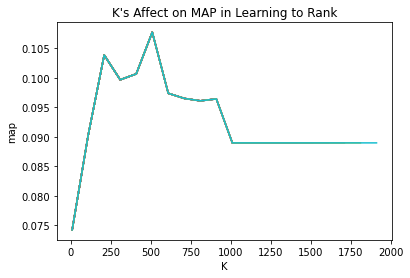

In [89]:
run_experiment(ltr_model, "map",incrementer=100,finish=2000, title = "K's Affect on MAP in Learning to Rank")

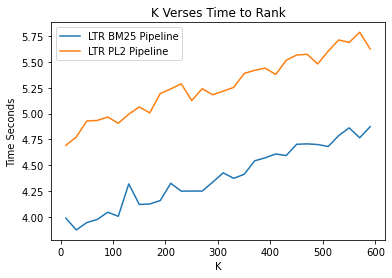

In [90]:
from datetime import datetime
def run_experiment_execution_time(trained_model, samples = 3, start= 10, finish = 600, incrementer = 20, title="K Verses Time to Rank"):
    k_list = []
    moe_list_mb25 = []
    moe_list_pl2 = []
    for k in range(start, finish, incrementer):
        total = 0.0
        for i in range(0, samples):
            start_time = datetime.now()
            efficient_pipeline = BM25 % k >> trained_model
            results = pt.pipelines.Experiment([efficient_pipeline], test_topics, qrels, ["map"], names=["model"])
            finish_time = datetime.now()
            elapse_time = (finish_time - start_time).total_seconds()
            total += elapse_time
        k_list.append(k)
        moe_list_mb25.append(total/samples)
        total = 0.0
        for i in range(0, samples):
            start_time = datetime.now()
            efficient_pipeline = PL2 % k >> trained_model
            results = pt.pipelines.Experiment([efficient_pipeline], test_topics, qrels, ["map"], names=["model"])
            finish_time = datetime.now()
            elapse_time = (finish_time - start_time).total_seconds()
            total += elapse_time
        moe_list_pl2.append(total/samples)
        
    plt.plot(k_list, moe_list_mb25, label="LTR BM25 Pipeline")
    plt.plot(k_list, moe_list_pl2, label="LTR PL2 Pipeline")
    plt.xlabel("K")
    plt.ylabel("Time Seconds")
    file_name = title.replace(" ", "-")
    plt.title(title)
    plt.legend()
    plt.savefig(file_name)
run_experiment_execution_time(ltr_model, incrementer=20)

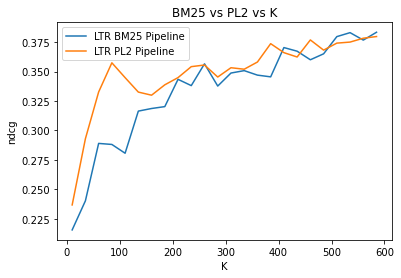

In [91]:
def run_experiment_model(trained_model, mop, start= 10, finish = 600, incrementer = 25, title="sample title"):
    k_list = []
    bm25_list = []
    pl2_list = []
    for k in range(start, finish, incrementer):
        efficient_pipeline_bm_52 = BM25 % k >> trained_model
        results = pt.pipelines.Experiment([efficient_pipeline_bm_52], test_topics, qrels, [mop], names=["model"])
        k_list.append(k)
        bm25_list.append(results[mop].iloc[0])
        
        efficient_pipeline_pl2 = PL2 % k >> trained_model
        results = pt.pipelines.Experiment([efficient_pipeline_pl2], test_topics, qrels, [mop], names=["model"])
        pl2_list.append(results[mop].iloc[0])
        
    plt.plot(k_list, bm25_list, label="LTR BM25 Pipeline")
    plt.plot(k_list, pl2_list, label="LTR PL2 Pipeline")
    plt.xlabel("K")
    plt.ylabel(mop)
    file_name = title.replace(" ", "-")
    plt.title(title)
    plt.legend()
    plt.savefig(file_name)
run_experiment_model(ltr_model,"ndcg", title="BM25 vs PL2 vs K")       
        

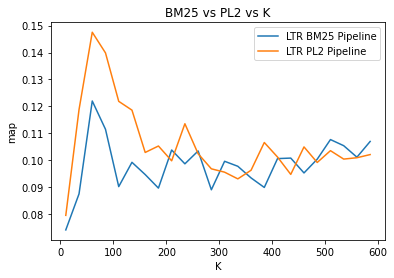

In [92]:
run_experiment_model(ltr_model,"map", title="BM25 vs PL2 vs K")       

In [93]:
pt.datasets.list_datasets()

,dataset,topics,qrels,corpus,index
0,50pct,None,None,None,True
1,vaswani,True,True,True,True
2,trec-deep-learning-docs,"(train, dev, test, test-2020, leaderboard-2020)","(train, dev, test)",True,None
3,trec-deep-learning-passages,"(train, dev, eval, test-2019)","(train, dev, test-2019)",True,None
4,trec-robust-2004,True,True,None,None
5,trec-robust-2005,True,True,None,None
6,trec-precision-medicine,"(2017, 2018, 2019, 2020)","(qrels-2017-abstracts, qrels-2017-abstracts-sa...",None,None
7,trec-covid,"(round1, round2, round3, round4, round5)","(round1, round2, round3, round3-cumulative, ro...","(round4, round5)",None
8,trec-wt2g,True,True,None,None
9,trec-wt-2002,"(td, np)","(np, td)",None,None


In [94]:
end = time.time()
print(end - start)

1728.935649394989
